In [1]:
import sys
import SimpleITK as sitk
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
import os
import fnmatch
import shutil
from ipywidgets import interact, fixed
import pandas as pd
from pathlib import Path

#function for showing volume images
def myshow(image_arr,slice_n):
    plt.imshow(image_arr[slice_n,:,:],cmap='gray')
    plt.show()

In [2]:
data = pd.read_csv('C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/survival_data.csv')
data.head(10)

BraTS18ID     Age  Survival ResectionStatus
0  Brats18_TCIA08_167_1  74.907       153             NaN
1  Brats18_TCIA08_242_1  66.479       147             NaN
2  Brats18_TCIA08_319_1  64.860       254             NaN
3  Brats18_TCIA08_469_1  63.899       519             NaN
4  Brats18_TCIA08_218_1  57.345       346             NaN
5  Brats18_TCIA08_406_1  78.745        82             NaN
6  Brats18_TCIA08_280_1  57.362       508             NaN
7  Brats18_TCIA08_105_1  66.627        77             NaN
8  Brats18_TCIA08_278_1  50.501      1458             NaN
9  Brats18_TCIA06_247_1  76.699       244             NaN

In [5]:
#making separate directories for different modalities in order
path = 'C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/'
path_HGG = 'C://Image Processing/brats data/new/HGG/'
path_LGG = 'C://Image Processing/brats data/new/LGG/'
list_of_dirs = ['t1','T1Gd','t2','flair']

def make_my_dirs(directory, names):
    for i in names: 
        os.makedirs(directory+i, exist_ok = True)

make_my_dirs(path_HGG, list_of_dirs)
make_my_dirs(path_LGG, list_of_dirs)

In [3]:
#creating lists with images of different modalities

common_list = []
t2_list = []
t1_list = []
t1ce_list = []
flair_list = []
seg_list = []
for (dirpath, dirnames, filenames) in os.walk('C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/'):
    for filename in filenames: 
        if filename.endswith('.csv')==False and 'seg' not in filename.split('.')[0]:
            common_list.append(os.path.join(dirpath,filename))
            if 't2' in filename.split('.')[0]: 
                t2_list.append(os.path.join(dirpath,filename))
            if 't1' in filename.split('.')[0] and 't1ce' not in filename.split('.')[0]:
                t1_list.append(os.path.join(dirpath,filename))
            if 't1ce' in filename.split('.')[0]:
                t1ce_list.append(os.path.join(dirpath,filename))
            if 'flair' in filename.split('.')[0]:
                flair_list.append(os.path.join(dirpath,filename))
        if 'seg' in filename.split('.')[0]:
            seg_list.append(os.path.join(dirpath,filename))

In [4]:
#All of Modalities` paths into one dataframe for further processing

paths_data=pd.DataFrame(np.column_stack([t1_list,t1ce_list,t2_list,flair_list,seg_list]),
                       columns=['t1_p','t1ce_p','t2_p','flair_p','seg_p'])

pd.set_option('display.max_colwidth', -1)
paths_data.loc[222,:]

t1_p       C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA09_254_1\Brats18_TCIA09_254_1_t1.nii.gz   
t1ce_p     C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA09_254_1\Brats18_TCIA09_254_1_t1ce.nii.gz 
t2_p       C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA09_254_1\Brats18_TCIA09_254_1_t2.nii.gz   
flair_p    C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA09_254_1\Brats18_TCIA09_254_1_flair.nii.gz
seg_p      C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA09_254_1\Brats18_TCIA09_254_1_seg.nii.gz  
Name: 222, dtype: object

In [12]:
len(t1_list)


285

In [5]:
def plot_spacing(l):
    ''' 

    this function helps to plot spacing histograms 
    
    l = list with files` paths 


    '''    
    temp_list=[]
    
    for image in l:
        image_read=sitk.ReadImage(image)
        value=list(image_read.GetSpacing())
        value = [round(i,2) for i in value ]
        temp_list.append((str(value)).strip('[]'))

    
    temp_df=pd.DataFrame(temp_list)
    
    
    plt.figure(figsize=(12,7))
    plt.suptitle('Pixel Spacing (x,y,z)',fontsize=20)
    ax=temp_df[0].value_counts().plot(kind='bar')
    ax.set_xlabel('pixel spacing (x,y,z) in mm',fontsize='large')
    ax.set_ylabel('patients count',fontsize='large')
    plt.show()



def plot_size(l):
    '''
    this function helps to plot size histograms 
    
    l = list with files` paths
    '''
    temp_list=[]
    
    for image in l:
        image_read=sitk.ReadImage(image)
        value=list(image_read.GetSize())
        value = [round(i,2) for i in value ]
        temp_list.append((str(value)).strip('[]'))

    
    temp_df=pd.DataFrame(temp_list)
    
    
    plt.figure(figsize=(12,7))
    plt.suptitle('Size',fontsize=20)
    ax=temp_df[0].value_counts().plot(kind='bar')
    ax.set_xlabel('Size ',fontsize='large')
    ax.set_ylabel('patients count',fontsize='large')
    plt.show()

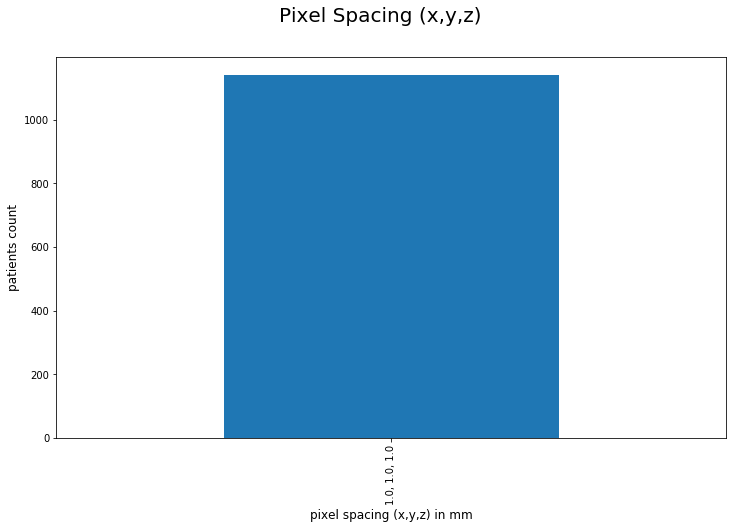

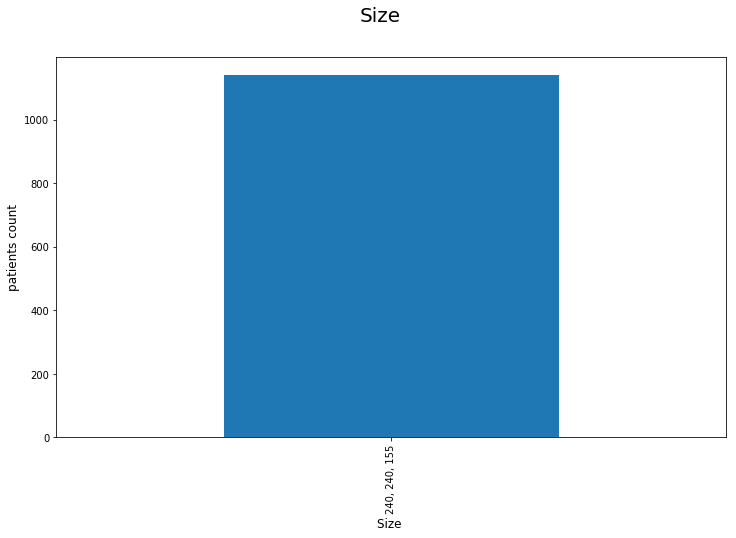

In [6]:
plot_spacing(common_list)
plot_size(common_list)

In [95]:
#For further processing we should plot Intensity Ranges
#Necessary because if it is differ we should normilize them

def plot_intensities(l,how='counts'):
    #plot intensity ranges 
    
    #l= path for the images
    
    #'counts' = plots all intensity ranges among all images
    #'min/max' = plots min and max values among all images
    
    temp_list_counts = []
    min_max_list = []
    
    def getMinMax(img):
        #Function that takes minimum and maximum value from one image
        mm = sitk.MinimumMaximumImageFilter()
        mm.Execute(img)
        return (mm.GetMinimum(), mm.GetMaximum())
    
    for image in l:
        image_read=sitk.ReadImage(image)
        value = getMinMax(image_read)
        temp_list_counts.append(str(value).strip('()'))
        for i in value:
            min_max_list.append(i)
    temp_df_counts=pd.DataFrame(temp_list_counts)
    
    if how=='counts':
    
        plt.figure(figsize=(12,7))
        plt.suptitle('Intensity Range', fontsize=20)
        ax=temp_df_counts[0].value_counts().plot(kind='bar')
        ax.set_xlabel('Intensities', fontsize='large')
        ax.set_ylabel('Counts',fontsize='large')
        plt.show()
    
    if how=='min/max':
        print('the minimum intesity value is:\t{}\nthe maximum intensity value is:\t{}'.format(min(min_max_list), max(min_max_list)))
    


In [9]:
#Checking Intensities before normalization 

#Intensity Ranges among all images

plot_intensities(common_list, how='min/max')

the minimum intesity value is:	0.0
the maximum intensity value is:	32767.0


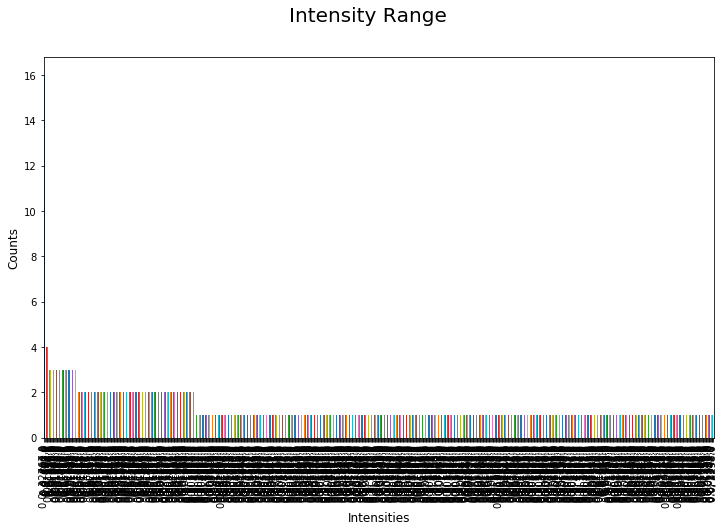

In [10]:
#Plotting Intensities Ranges
#Very heterogenous results

plot_intensities(common_list)

# Normalization to [-127,127] scale range 

In [ ]:
sitk.WriteImage(img, os.path.join(OUTPUT_DIR, 'SimpleITK.png'))

In [ ]:
#Rescaling by Linear Function 

#another way to normalize images (slower), but more precise

OUT_DIR = './all_modalities/'


def rescale_to(l, newmin_value = -127.0, newmax_value = 127.0, out_dir = OUT_DIR):
    
    
    
    #defining function which is going to rescale values to predefined values` range
    def to_norm(im_arr, newmin = newmin_value, newmax = newmax_value):
        norm_arr = (im_arr - im_arr.min()) * ((newmax - newmin) / (im_arr.max() - im_arr.min())) + newmin
        return norm_arr
    
    
    for i in l: 
        image = sitk.ReadImage(i)
        im_arr = sitk.GetArrayFromImage(image)
        normed_arr = to_norm(im_arr)
        normed_im = sitk.GetImageFromArray(normed_arr) #Getting image from normed array 
        
        #write normed image to output_dir
        name =  i.split('\\')[-1]
        sitk.WriteImage(normed_im, os.path.join(out_dir, name))
        
        print('{} rescaled and written to {}'.format(name, out_dir))

        
        
        
rescale_to(common_list)

In [11]:
#Rescaling by RescaleIntensityImageFilter() 

out_dir = './all_modalities/'

def norm_all(l):
    #set intensity scale to the range of [-127,127]
    imadjust = sitk.RescaleIntensityImageFilter()
    imadjust.SetOutputMinimum( -127 )
    imadjust.SetOutputMaximum( 127 )    
    for image in l: 
        im=sitk.ReadImage(image)
        print(image, '\tread')
        norm_im=imadjust.Execute( im )
        print(image, '\tnormalized')
        name =  image.split('\\')[-1]
        sitk.WriteImage(norm_im, os.path.join(out_dir, name))
        
        print('{} normalized and written to {}'.format(name, out_dir))
        
            
        
norm_all(common_list) #applying         

C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_2013_10_1\Brats18_2013_10_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_2013_10_1\Brats18_2013_10_1_flair.nii.gz 	normalized
Brats18_2013_10_1_flair.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_2013_10_1\Brats18_2013_10_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_2013_10_1\Brats18_2013_10_1_t1.nii.gz 	normalized
Brats18_2013_10_1_t1.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_2013_10_1\Brats18_2013_10_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_2013_10_1\Brats18_2013_10_1_t1ce.nii.gz 	normalized
Brats18_2013_10_1_t1ce.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data

Brats18_2013_18_1_t1.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_2013_18_1\Brats18_2013_18_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_2013_18_1\Brats18_2013_18_1_t1ce.nii.gz 	normalized
Brats18_2013_18_1_t1ce.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_2013_18_1\Brats18_2013_18_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_2013_18_1\Brats18_2013_18_1_t2.nii.gz 	normalized
Brats18_2013_18_1_t2.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_2013_19_1\Brats18_2013_19_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_2013_19_1\Brats18_2013_19_1_flair.nii.gz 	normalized
Brats18_2013_19_1_flair.nii.gz nor

C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_2013_25_1\Brats18_2013_25_1_t2.nii.gz 	normalized
Brats18_2013_25_1_t2.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_2013_26_1\Brats18_2013_26_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_2013_26_1\Brats18_2013_26_1_flair.nii.gz 	normalized
Brats18_2013_26_1_flair.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_2013_26_1\Brats18_2013_26_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_2013_26_1\Brats18_2013_26_1_t1.nii.gz 	normalized
Brats18_2013_26_1_t1.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_2013_26_1\Brats18_2013_26_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MIC

C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_2013_7_1\Brats18_2013_7_1_t1.nii.gz 	normalized
Brats18_2013_7_1_t1.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_2013_7_1\Brats18_2013_7_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_2013_7_1\Brats18_2013_7_1_t1ce.nii.gz 	normalized
Brats18_2013_7_1_t1ce.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_2013_7_1\Brats18_2013_7_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_2013_7_1\Brats18_2013_7_1_t2.nii.gz 	normalized
Brats18_2013_7_1_t2.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AAB_1\Brats18_CBICA_AAB_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2

C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ABE_1\Brats18_CBICA_ABE_1_t1ce.nii.gz 	normalized
Brats18_CBICA_ABE_1_t1ce.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ABE_1\Brats18_CBICA_ABE_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ABE_1\Brats18_CBICA_ABE_1_t2.nii.gz 	normalized
Brats18_CBICA_ABE_1_t2.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ABM_1\Brats18_CBICA_ABM_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ABM_1\Brats18_CBICA_ABM_1_flair.nii.gz 	normalized
Brats18_CBICA_ABM_1_flair.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ABM_1\Brats18_CBICA_ABM_1_t1.nii.gz 	read
C:/

C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ALU_1\Brats18_CBICA_ALU_1_t2.nii.gz 	normalized
Brats18_CBICA_ALU_1_t2.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ALX_1\Brats18_CBICA_ALX_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ALX_1\Brats18_CBICA_ALX_1_flair.nii.gz 	normalized
Brats18_CBICA_ALX_1_flair.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ALX_1\Brats18_CBICA_ALX_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ALX_1\Brats18_CBICA_ALX_1_t1.nii.gz 	normalized
Brats18_CBICA_ALX_1_t1.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ALX_1\Brats18_CBICA_ALX_1_t1ce.nii.gz 	read
C://I

C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ANZ_1\Brats18_CBICA_ANZ_1_flair.nii.gz 	normalized
Brats18_CBICA_ANZ_1_flair.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ANZ_1\Brats18_CBICA_ANZ_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ANZ_1\Brats18_CBICA_ANZ_1_t1.nii.gz 	normalized
Brats18_CBICA_ANZ_1_t1.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ANZ_1\Brats18_CBICA_ANZ_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ANZ_1\Brats18_CBICA_ANZ_1_t1ce.nii.gz 	normalized
Brats18_CBICA_ANZ_1_t1ce.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ANZ_1\Brats18_CBICA_ANZ_1_t2.nii.gz 	read
C://

C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_APR_1\Brats18_CBICA_APR_1_t1.nii.gz 	normalized
Brats18_CBICA_APR_1_t1.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_APR_1\Brats18_CBICA_APR_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_APR_1\Brats18_CBICA_APR_1_t1ce.nii.gz 	normalized
Brats18_CBICA_APR_1_t1ce.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_APR_1\Brats18_CBICA_APR_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_APR_1\Brats18_CBICA_APR_1_t2.nii.gz 	normalized
Brats18_CBICA_APR_1_t2.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_APY_1\Brats18_CBICA_APY_1_flair.nii.gz 	read
C://Ima

C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AQJ_1\Brats18_CBICA_AQJ_1_t1ce.nii.gz 	normalized
Brats18_CBICA_AQJ_1_t1ce.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AQJ_1\Brats18_CBICA_AQJ_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AQJ_1\Brats18_CBICA_AQJ_1_t2.nii.gz 	normalized
Brats18_CBICA_AQJ_1_t2.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AQN_1\Brats18_CBICA_AQN_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AQN_1\Brats18_CBICA_AQN_1_flair.nii.gz 	normalized
Brats18_CBICA_AQN_1_flair.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AQN_1\Brats18_CBICA_AQN_1_t1.nii.gz 	read
C:/

C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AQT_1\Brats18_CBICA_AQT_1_t2.nii.gz 	normalized
Brats18_CBICA_AQT_1_t2.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AQU_1\Brats18_CBICA_AQU_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AQU_1\Brats18_CBICA_AQU_1_flair.nii.gz 	normalized
Brats18_CBICA_AQU_1_flair.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AQU_1\Brats18_CBICA_AQU_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AQU_1\Brats18_CBICA_AQU_1_t1.nii.gz 	normalized
Brats18_CBICA_AQU_1_t1.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AQU_1\Brats18_CBICA_AQU_1_t1ce.nii.gz 	read
C://I

C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ARZ_1\Brats18_CBICA_ARZ_1_flair.nii.gz 	normalized
Brats18_CBICA_ARZ_1_flair.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ARZ_1\Brats18_CBICA_ARZ_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ARZ_1\Brats18_CBICA_ARZ_1_t1.nii.gz 	normalized
Brats18_CBICA_ARZ_1_t1.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ARZ_1\Brats18_CBICA_ARZ_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ARZ_1\Brats18_CBICA_ARZ_1_t1ce.nii.gz 	normalized
Brats18_CBICA_ARZ_1_t1ce.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ARZ_1\Brats18_CBICA_ARZ_1_t2.nii.gz 	read
C://

C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ASN_1\Brats18_CBICA_ASN_1_t1.nii.gz 	normalized
Brats18_CBICA_ASN_1_t1.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ASN_1\Brats18_CBICA_ASN_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ASN_1\Brats18_CBICA_ASN_1_t1ce.nii.gz 	normalized
Brats18_CBICA_ASN_1_t1ce.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ASN_1\Brats18_CBICA_ASN_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ASN_1\Brats18_CBICA_ASN_1_t2.nii.gz 	normalized
Brats18_CBICA_ASN_1_t2.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ASO_1\Brats18_CBICA_ASO_1_flair.nii.gz 	read
C://Ima

C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ATB_1\Brats18_CBICA_ATB_1_t1ce.nii.gz 	normalized
Brats18_CBICA_ATB_1_t1ce.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ATB_1\Brats18_CBICA_ATB_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ATB_1\Brats18_CBICA_ATB_1_t2.nii.gz 	normalized
Brats18_CBICA_ATB_1_t2.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ATD_1\Brats18_CBICA_ATD_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ATD_1\Brats18_CBICA_ATD_1_flair.nii.gz 	normalized
Brats18_CBICA_ATD_1_flair.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_ATD_1\Brats18_CBICA_ATD_1_t1.nii.gz 	read
C:/

C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AUN_1\Brats18_CBICA_AUN_1_t2.nii.gz 	normalized
Brats18_CBICA_AUN_1_t2.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AUQ_1\Brats18_CBICA_AUQ_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AUQ_1\Brats18_CBICA_AUQ_1_flair.nii.gz 	normalized
Brats18_CBICA_AUQ_1_flair.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AUQ_1\Brats18_CBICA_AUQ_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AUQ_1\Brats18_CBICA_AUQ_1_t1.nii.gz 	normalized
Brats18_CBICA_AUQ_1_t1.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AUQ_1\Brats18_CBICA_AUQ_1_t1ce.nii.gz 	read
C://I

C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AWH_1\Brats18_CBICA_AWH_1_flair.nii.gz 	normalized
Brats18_CBICA_AWH_1_flair.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AWH_1\Brats18_CBICA_AWH_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AWH_1\Brats18_CBICA_AWH_1_t1.nii.gz 	normalized
Brats18_CBICA_AWH_1_t1.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AWH_1\Brats18_CBICA_AWH_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AWH_1\Brats18_CBICA_AWH_1_t1ce.nii.gz 	normalized
Brats18_CBICA_AWH_1_t1ce.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AWH_1\Brats18_CBICA_AWH_1_t2.nii.gz 	read
C://

C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AXO_1\Brats18_CBICA_AXO_1_t1.nii.gz 	normalized
Brats18_CBICA_AXO_1_t1.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AXO_1\Brats18_CBICA_AXO_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AXO_1\Brats18_CBICA_AXO_1_t1ce.nii.gz 	normalized
Brats18_CBICA_AXO_1_t1ce.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AXO_1\Brats18_CBICA_AXO_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AXO_1\Brats18_CBICA_AXO_1_t2.nii.gz 	normalized
Brats18_CBICA_AXO_1_t2.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AXQ_1\Brats18_CBICA_AXQ_1_flair.nii.gz 	read
C://Ima

C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AYW_1\Brats18_CBICA_AYW_1_t1ce.nii.gz 	normalized
Brats18_CBICA_AYW_1_t1ce.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AYW_1\Brats18_CBICA_AYW_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AYW_1\Brats18_CBICA_AYW_1_t2.nii.gz 	normalized
Brats18_CBICA_AYW_1_t2.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AZD_1\Brats18_CBICA_AZD_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AZD_1\Brats18_CBICA_AZD_1_flair.nii.gz 	normalized
Brats18_CBICA_AZD_1_flair.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_AZD_1\Brats18_CBICA_AZD_1_t1.nii.gz 	read
C:/

C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_BHK_1\Brats18_CBICA_BHK_1_t2.nii.gz 	normalized
Brats18_CBICA_BHK_1_t2.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_BHM_1\Brats18_CBICA_BHM_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_BHM_1\Brats18_CBICA_BHM_1_flair.nii.gz 	normalized
Brats18_CBICA_BHM_1_flair.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_BHM_1\Brats18_CBICA_BHM_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_BHM_1\Brats18_CBICA_BHM_1_t1.nii.gz 	normalized
Brats18_CBICA_BHM_1_t1.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_CBICA_BHM_1\Brats18_CBICA_BHM_1_t1ce.nii.gz 	read
C://I

C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA01_190_1\Brats18_TCIA01_190_1_flair.nii.gz 	normalized
Brats18_TCIA01_190_1_flair.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA01_190_1\Brats18_TCIA01_190_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA01_190_1\Brats18_TCIA01_190_1_t1.nii.gz 	normalized
Brats18_TCIA01_190_1_t1.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA01_190_1\Brats18_TCIA01_190_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA01_190_1\Brats18_TCIA01_190_1_t1ce.nii.gz 	normalized
Brats18_TCIA01_190_1_t1ce.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA01_190_1\Brats18_TCIA01_190_1_t2.ni

Brats18_TCIA01_335_1_flair.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA01_335_1\Brats18_TCIA01_335_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA01_335_1\Brats18_TCIA01_335_1_t1.nii.gz 	normalized
Brats18_TCIA01_335_1_t1.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA01_335_1\Brats18_TCIA01_335_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA01_335_1\Brats18_TCIA01_335_1_t1ce.nii.gz 	normalized
Brats18_TCIA01_335_1_t1ce.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA01_335_1\Brats18_TCIA01_335_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA01_335_1\Brats18_TCIA01_335_1_t2.nii.gz 	nor

C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA01_425_1\Brats18_TCIA01_425_1_t1.nii.gz 	normalized
Brats18_TCIA01_425_1_t1.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA01_425_1\Brats18_TCIA01_425_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA01_425_1\Brats18_TCIA01_425_1_t1ce.nii.gz 	normalized
Brats18_TCIA01_425_1_t1ce.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA01_425_1\Brats18_TCIA01_425_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA01_425_1\Brats18_TCIA01_425_1_t2.nii.gz 	normalized
Brats18_TCIA01_425_1_t2.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA01_429_1\Brats18_TCIA01_429_1_flair.nii.g

Brats18_TCIA02_118_1_t1.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_118_1\Brats18_TCIA02_118_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_118_1\Brats18_TCIA02_118_1_t1ce.nii.gz 	normalized
Brats18_TCIA02_118_1_t1ce.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_118_1\Brats18_TCIA02_118_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_118_1\Brats18_TCIA02_118_1_t2.nii.gz 	normalized
Brats18_TCIA02_118_1_t2.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_135_1\Brats18_TCIA02_135_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_135_1\Brats18_TCIA02_135_1_flair.nii.gz 	

C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_198_1\Brats18_TCIA02_198_1_t1ce.nii.gz 	normalized
Brats18_TCIA02_198_1_t1ce.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_198_1\Brats18_TCIA02_198_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_198_1\Brats18_TCIA02_198_1_t2.nii.gz 	normalized
Brats18_TCIA02_198_1_t2.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_208_1\Brats18_TCIA02_208_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_208_1\Brats18_TCIA02_208_1_flair.nii.gz 	normalized
Brats18_TCIA02_208_1_flair.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_208_1\Brats18_TCIA02_208_1_t1.n

Brats18_TCIA02_290_1_t1ce.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_290_1\Brats18_TCIA02_290_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_290_1\Brats18_TCIA02_290_1_t2.nii.gz 	normalized
Brats18_TCIA02_290_1_t2.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_300_1\Brats18_TCIA02_300_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_300_1\Brats18_TCIA02_300_1_flair.nii.gz 	normalized
Brats18_TCIA02_300_1_flair.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_300_1\Brats18_TCIA02_300_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_300_1\Brats18_TCIA02_300_1_t1.nii.gz 	n

C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_331_1\Brats18_TCIA02_331_1_t2.nii.gz 	normalized
Brats18_TCIA02_331_1_t2.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_368_1\Brats18_TCIA02_368_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_368_1\Brats18_TCIA02_368_1_flair.nii.gz 	normalized
Brats18_TCIA02_368_1_flair.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_368_1\Brats18_TCIA02_368_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_368_1\Brats18_TCIA02_368_1_t1.nii.gz 	normalized
Brats18_TCIA02_368_1_t1.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_368_1\Brats18_TCIA02_368_1_t1ce.nii

Brats18_TCIA02_430_1_t2.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_455_1\Brats18_TCIA02_455_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_455_1\Brats18_TCIA02_455_1_flair.nii.gz 	normalized
Brats18_TCIA02_455_1_flair.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_455_1\Brats18_TCIA02_455_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_455_1\Brats18_TCIA02_455_1_t1.nii.gz 	normalized
Brats18_TCIA02_455_1_t1.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_455_1\Brats18_TCIA02_455_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_455_1\Brats18_TCIA02_455_1_t1ce.nii.gz 

C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_607_1\Brats18_TCIA02_607_1_flair.nii.gz 	normalized
Brats18_TCIA02_607_1_flair.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_607_1\Brats18_TCIA02_607_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_607_1\Brats18_TCIA02_607_1_t1.nii.gz 	normalized
Brats18_TCIA02_607_1_t1.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_607_1\Brats18_TCIA02_607_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_607_1\Brats18_TCIA02_607_1_t1ce.nii.gz 	normalized
Brats18_TCIA02_607_1_t1ce.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA02_607_1\Brats18_TCIA02_607_1_t2.ni

Brats18_TCIA03_257_1_flair.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA03_257_1\Brats18_TCIA03_257_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA03_257_1\Brats18_TCIA03_257_1_t1.nii.gz 	normalized
Brats18_TCIA03_257_1_t1.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA03_257_1\Brats18_TCIA03_257_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA03_257_1\Brats18_TCIA03_257_1_t1ce.nii.gz 	normalized
Brats18_TCIA03_257_1_t1ce.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA03_257_1\Brats18_TCIA03_257_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA03_257_1\Brats18_TCIA03_257_1_t2.nii.gz 	nor

C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA03_474_1\Brats18_TCIA03_474_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA03_474_1\Brats18_TCIA03_474_1_t1.nii.gz 	normalized
Brats18_TCIA03_474_1_t1.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA03_474_1\Brats18_TCIA03_474_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA03_474_1\Brats18_TCIA03_474_1_t1ce.nii.gz 	normalized
Brats18_TCIA03_474_1_t1ce.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA03_474_1\Brats18_TCIA03_474_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA03_474_1\Brats18_TCIA03_474_1_t2.nii.gz 	normalized
Brats18_TCIA03_474_1_t2.nii.gz normalized and written to ./all_modalit

C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA04_343_1\Brats18_TCIA04_343_1_t1.nii.gz 	normalized
Brats18_TCIA04_343_1_t1.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA04_343_1\Brats18_TCIA04_343_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA04_343_1\Brats18_TCIA04_343_1_t1ce.nii.gz 	normalized
Brats18_TCIA04_343_1_t1ce.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA04_343_1\Brats18_TCIA04_343_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA04_343_1\Brats18_TCIA04_343_1_t2.nii.gz 	normalized
Brats18_TCIA04_343_1_t2.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA04_361_1\Brats18_TCIA04_361_1_flair.nii.g

Brats18_TCIA05_444_1_t1.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA05_444_1\Brats18_TCIA05_444_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA05_444_1\Brats18_TCIA05_444_1_t1ce.nii.gz 	normalized
Brats18_TCIA05_444_1_t1ce.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA05_444_1\Brats18_TCIA05_444_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA05_444_1\Brats18_TCIA05_444_1_t2.nii.gz 	normalized
Brats18_TCIA05_444_1_t2.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA05_478_1\Brats18_TCIA05_478_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA05_478_1\Brats18_TCIA05_478_1_flair.nii.gz 	

C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA06_332_1\Brats18_TCIA06_332_1_t1ce.nii.gz 	normalized
Brats18_TCIA06_332_1_t1ce.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA06_332_1\Brats18_TCIA06_332_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA06_332_1\Brats18_TCIA06_332_1_t2.nii.gz 	normalized
Brats18_TCIA06_332_1_t2.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA06_372_1\Brats18_TCIA06_372_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA06_372_1\Brats18_TCIA06_372_1_flair.nii.gz 	normalized
Brats18_TCIA06_372_1_flair.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA06_372_1\Brats18_TCIA06_372_1_t1.n

C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA08_162_1\Brats18_TCIA08_162_1_t1ce.nii.gz 	normalized
Brats18_TCIA08_162_1_t1ce.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA08_162_1\Brats18_TCIA08_162_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA08_162_1\Brats18_TCIA08_162_1_t2.nii.gz 	normalized
Brats18_TCIA08_162_1_t2.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA08_167_1\Brats18_TCIA08_167_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA08_167_1\Brats18_TCIA08_167_1_flair.nii.gz 	normalized
Brats18_TCIA08_167_1_flair.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA08_167_1\Brats18_TCIA08_167_1_t1.n

Brats18_TCIA08_278_1_t1ce.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA08_278_1\Brats18_TCIA08_278_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA08_278_1\Brats18_TCIA08_278_1_t2.nii.gz 	normalized
Brats18_TCIA08_278_1_t2.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA08_280_1\Brats18_TCIA08_280_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA08_280_1\Brats18_TCIA08_280_1_flair.nii.gz 	normalized
Brats18_TCIA08_280_1_flair.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA08_280_1\Brats18_TCIA08_280_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/HGG\Brats18_TCIA08_280_1\Brats18_TCIA08_280_1_t1.nii.gz 	n

C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_2013_0_1\Brats18_2013_0_1_t2.nii.gz 	normalized
Brats18_2013_0_1_t2.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_2013_15_1\Brats18_2013_15_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_2013_15_1\Brats18_2013_15_1_flair.nii.gz 	normalized
Brats18_2013_15_1_flair.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_2013_15_1\Brats18_2013_15_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_2013_15_1\Brats18_2013_15_1_t1.nii.gz 	normalized
Brats18_2013_15_1_t1.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_2013_15_1\Brats18_2013_15_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI

C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_2013_6_1\Brats18_2013_6_1_t1.nii.gz 	normalized
Brats18_2013_6_1_t1.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_2013_6_1\Brats18_2013_6_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_2013_6_1\Brats18_2013_6_1_t1ce.nii.gz 	normalized
Brats18_2013_6_1_t1ce.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_2013_6_1\Brats18_2013_6_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_2013_6_1\Brats18_2013_6_1_t2.nii.gz 	normalized
Brats18_2013_6_1_t2.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_2013_8_1\Brats18_2013_8_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Da

C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA09_255_1\Brats18_TCIA09_255_1_t1ce.nii.gz 	normalized
Brats18_TCIA09_255_1_t1ce.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA09_255_1\Brats18_TCIA09_255_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA09_255_1\Brats18_TCIA09_255_1_t2.nii.gz 	normalized
Brats18_TCIA09_255_1_t2.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA09_312_1\Brats18_TCIA09_312_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA09_312_1\Brats18_TCIA09_312_1_flair.nii.gz 	normalized
Brats18_TCIA09_312_1_flair.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA09_312_1\Brats18_TCIA09_312_1_t1.n

Brats18_TCIA09_493_1_t1ce.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA09_493_1\Brats18_TCIA09_493_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA09_493_1\Brats18_TCIA09_493_1_t2.nii.gz 	normalized
Brats18_TCIA09_493_1_t2.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA09_620_1\Brats18_TCIA09_620_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA09_620_1\Brats18_TCIA09_620_1_flair.nii.gz 	normalized
Brats18_TCIA09_620_1_flair.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA09_620_1\Brats18_TCIA09_620_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA09_620_1\Brats18_TCIA09_620_1_t1.nii.gz 	n

Brats18_TCIA10_175_1_t2.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_202_1\Brats18_TCIA10_202_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_202_1\Brats18_TCIA10_202_1_flair.nii.gz 	normalized
Brats18_TCIA10_202_1_flair.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_202_1\Brats18_TCIA10_202_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_202_1\Brats18_TCIA10_202_1_t1.nii.gz 	normalized
Brats18_TCIA10_202_1_t1.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_202_1\Brats18_TCIA10_202_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_202_1\Brats18_TCIA10_202_1_t1ce.nii.gz 

C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_299_1\Brats18_TCIA10_299_1_flair.nii.gz 	normalized
Brats18_TCIA10_299_1_flair.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_299_1\Brats18_TCIA10_299_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_299_1\Brats18_TCIA10_299_1_t1.nii.gz 	normalized
Brats18_TCIA10_299_1_t1.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_299_1\Brats18_TCIA10_299_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_299_1\Brats18_TCIA10_299_1_t1ce.nii.gz 	normalized
Brats18_TCIA10_299_1_t1ce.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_299_1\Brats18_TCIA10_299_1_t2.ni

Brats18_TCIA10_351_1_flair.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_351_1\Brats18_TCIA10_351_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_351_1\Brats18_TCIA10_351_1_t1.nii.gz 	normalized
Brats18_TCIA10_351_1_t1.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_351_1\Brats18_TCIA10_351_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_351_1\Brats18_TCIA10_351_1_t1ce.nii.gz 	normalized
Brats18_TCIA10_351_1_t1ce.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_351_1\Brats18_TCIA10_351_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_351_1\Brats18_TCIA10_351_1_t2.nii.gz 	nor

C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_420_1\Brats18_TCIA10_420_1_t1.nii.gz 	normalized
Brats18_TCIA10_420_1_t1.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_420_1\Brats18_TCIA10_420_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_420_1\Brats18_TCIA10_420_1_t1ce.nii.gz 	normalized
Brats18_TCIA10_420_1_t1ce.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_420_1\Brats18_TCIA10_420_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_420_1\Brats18_TCIA10_420_1_t2.nii.gz 	normalized
Brats18_TCIA10_420_1_t2.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_442_1\Brats18_TCIA10_442_1_flair.nii.g

C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_629_1\Brats18_TCIA10_629_1_t1.nii.gz 	normalized
Brats18_TCIA10_629_1_t1.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_629_1\Brats18_TCIA10_629_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_629_1\Brats18_TCIA10_629_1_t1ce.nii.gz 	normalized
Brats18_TCIA10_629_1_t1ce.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_629_1\Brats18_TCIA10_629_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_629_1\Brats18_TCIA10_629_1_t2.nii.gz 	normalized
Brats18_TCIA10_629_1_t2.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA10_632_1\Brats18_TCIA10_632_1_flair.nii.g

Brats18_TCIA12_101_1_t1.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA12_101_1\Brats18_TCIA12_101_1_t1ce.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA12_101_1\Brats18_TCIA12_101_1_t1ce.nii.gz 	normalized
Brats18_TCIA12_101_1_t1ce.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA12_101_1\Brats18_TCIA12_101_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA12_101_1\Brats18_TCIA12_101_1_t2.nii.gz 	normalized
Brats18_TCIA12_101_1_t2.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA12_249_1\Brats18_TCIA12_249_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA12_249_1\Brats18_TCIA12_249_1_flair.nii.gz 	

C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA13_615_1\Brats18_TCIA13_615_1_t1ce.nii.gz 	normalized
Brats18_TCIA13_615_1_t1ce.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA13_615_1\Brats18_TCIA13_615_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA13_615_1\Brats18_TCIA13_615_1_t2.nii.gz 	normalized
Brats18_TCIA13_615_1_t2.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA13_618_1\Brats18_TCIA13_618_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA13_618_1\Brats18_TCIA13_618_1_flair.nii.gz 	normalized
Brats18_TCIA13_618_1_flair.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA13_618_1\Brats18_TCIA13_618_1_t1.n

Brats18_TCIA13_633_1_t1ce.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA13_633_1\Brats18_TCIA13_633_1_t2.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA13_633_1\Brats18_TCIA13_633_1_t2.nii.gz 	normalized
Brats18_TCIA13_633_1_t2.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA13_634_1\Brats18_TCIA13_634_1_flair.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA13_634_1\Brats18_TCIA13_634_1_flair.nii.gz 	normalized
Brats18_TCIA13_634_1_flair.nii.gz normalized and written to ./all_modalities/
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA13_634_1\Brats18_TCIA13_634_1_t1.nii.gz 	read
C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA13_634_1\Brats18_TCIA13_634_1_t1.nii.gz 	n

C://Image Processing/brats data/MICCAI_BraTS_2018_Data_Training/LGG\Brats18_TCIA13_654_1\Brats18_TCIA13_654_1_t2.nii.gz 	normalized
Brats18_TCIA13_654_1_t2.nii.gz normalized and written to ./all_modalities/


In [93]:
#new list with paths for normalized images

new_path = './all_modalities/'
new_dir = os.listdir(new_path)
normalized_list = [new_path+i for i in new_dir]
normalized_list

['./all_modalities/Brats18_2013_0_1_flair.nii.gz',
 './all_modalities/Brats18_2013_0_1_t1.nii.gz',
 './all_modalities/Brats18_2013_0_1_t1ce.nii.gz',
 './all_modalities/Brats18_2013_0_1_t2.nii.gz',
 './all_modalities/Brats18_2013_10_1_flair.nii.gz',
 './all_modalities/Brats18_2013_10_1_t1.nii.gz',
 './all_modalities/Brats18_2013_10_1_t1ce.nii.gz',
 './all_modalities/Brats18_2013_10_1_t2.nii.gz',
 './all_modalities/Brats18_2013_11_1_flair.nii.gz',
 './all_modalities/Brats18_2013_11_1_t1.nii.gz',
 './all_modalities/Brats18_2013_11_1_t1ce.nii.gz',
 './all_modalities/Brats18_2013_11_1_t2.nii.gz',
 './all_modalities/Brats18_2013_12_1_flair.nii.gz',
 './all_modalities/Brats18_2013_12_1_t1.nii.gz',
 './all_modalities/Brats18_2013_12_1_t1ce.nii.gz',
 './all_modalities/Brats18_2013_12_1_t2.nii.gz',
 './all_modalities/Brats18_2013_13_1_flair.nii.gz',
 './all_modalities/Brats18_2013_13_1_t1.nii.gz',
 './all_modalities/Brats18_2013_13_1_t1ce.nii.gz',
 './all_modalities/Brats18_2013_13_1_t2.nii.gz',

In [96]:
#checking range 

plot_intensities(normalized_list, how='min/max')

#values are in the appropriate range 

the minimum intesity value is:	-127.0
the maximum intensity value is:	127.00000000000003


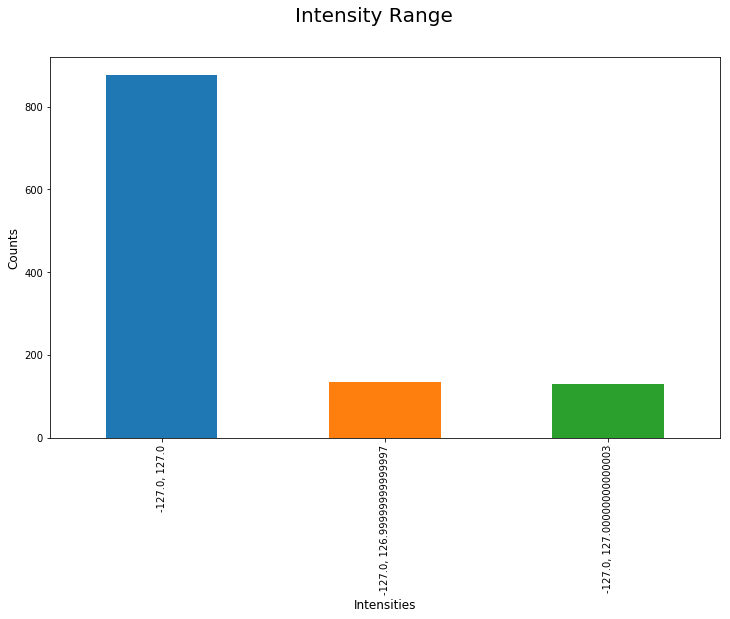

In [97]:
#plotting results of normalization 

plot_intensities(normalized_list)

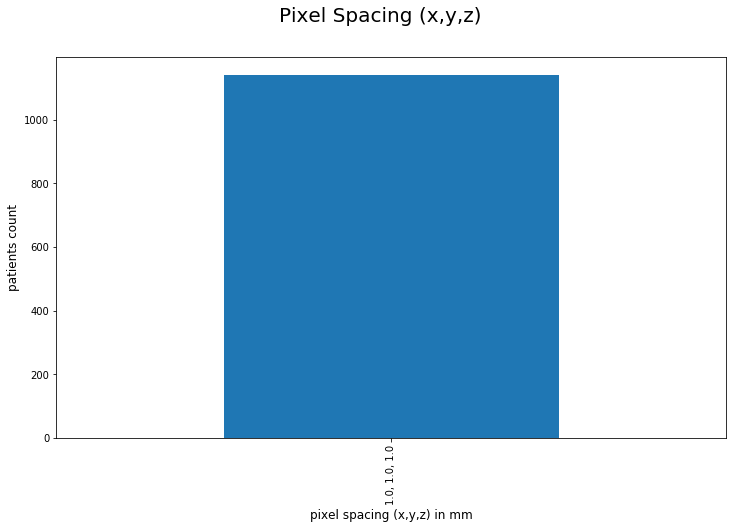

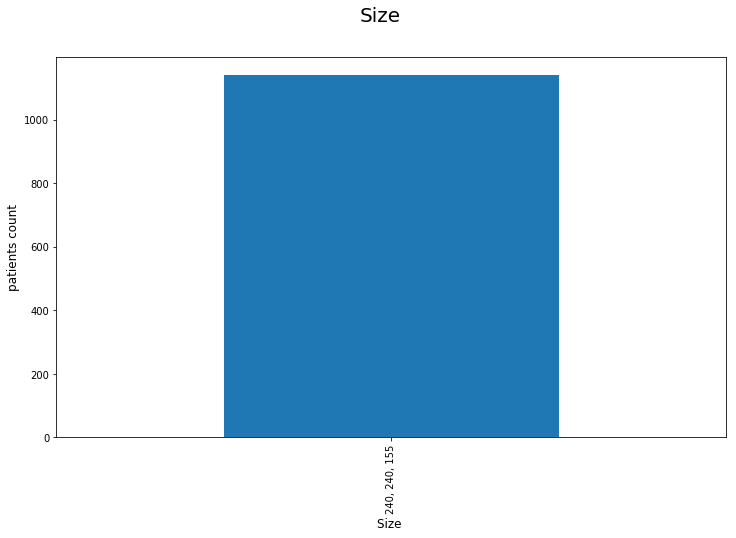

In [98]:
plot_spacing(normalized_list)
plot_size(normalized_list)

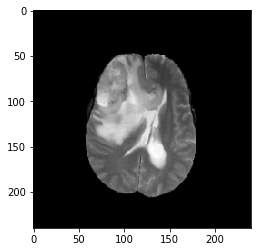

In [122]:
im = sitk.ReadImage(normalized_list[15])
im_arr=sitk.GetArrayFromImage(im)

myshow(im_arr,85)